<a href="https://colab.research.google.com/github/hermionewarr/Transfer_learning_sarcopenia_C3/blob/main/3_automatic_segmentation_c3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installations and definitions

> includes custom dataset class



Image segmentation using fcn resnet. Need to classify pixels as muscle or not_muscle.

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
!pip install torchsummary

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import ndimage
import cv2
from google.colab.patches import cv2_imshow
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import segmentation_models_pytorch as smp
from PIL import Image
import time
#from __future__ import division
import copy
from tqdm import tqdm
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import albumentations as A
import random
from albumentations.pytorch import ToTensor
from torch.utils.tensorboard import SummaryWriter
from functools import partial

In [ ]:
#import tensorflow as tf
#tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [ ]:
def preprocess(slice_array, masks_array):
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  window = 350
  level = 50
  size = len(masks_array)
  vmin = (level/2) - window
  vmax = (level/2) + window
  processed_slices = []
  processed_masks = (np.nan_to_num(masks_array)).astype(np.float64)
  for i in range (0, size):
    slice_array[i][slice_array[i]>vmax] = vmax
    slice_array[i][slice_array[i]<vmin] = vmin
    shape = slice_array[i].shape
    image_scaled = np.round(sklearn.preprocessing.minmax_scale(slice_array[i].ravel(), feature_range=(0,1)), decimals = 10).reshape(shape)
    processed_slices.append(image_scaled)
    processed_masks[i][processed_masks[i]>1] = 1
  processed_slices = np.array(processed_slices)
  return processed_slices, processed_masks

def genTransforms(slice_array, masks_array):
  transform_slices = []
  transform_masks = []
  size = len(masks_array)
  #masks = masks_array[:,np.newaxis,:,:]
  if slice_array.shape != (size,3,...):
    slices_3chan = np.repeat(slice_array[:,:,:,np.newaxis], 3, axis=-1)
    #slice_array = np.moveaxis(slices_3chan, 3,1)
  transform_slice = slices_3chan.astype(np.float32)
  transform_mask = masks_array.astype(np.float32)
  #print("maybe here?",transform_mask.shape)
  return transform_slice, transform_mask

def diceCoeff(pred, gt, smooth=1, activation='sigmoid'):
    """ computational formula：
        dice = (2 * (pred ∩ gt)) / (pred ∪ gt)
    """
    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = nn.Softmax2d()
    else:
        raise NotImplementedError("Activation implemented for sigmoid and softmax2d activation function operation")
 
    pred = np.round(activation_fn(pred))
    N = gt.size(0) #n should be batch size
    pred_flat = pred.view(N, -1)
    gt_flat = gt.view(N, -1)
 
    intersection = (pred_flat * gt_flat).sum(1)
    unionset = pred_flat.sum(1) + gt_flat.sum(1)
    print(intersection, unionset)
    loss = (2 * intersection + smooth) / (unionset + smooth)
 
    return loss.sum() / N

def getDensity(image, mask, area, label=1):#pixel density
  if image.shape != (len(image),1,...):
    mask = np.squeeze(mask)
  # remove image.data since passing array
  return float(np.mean(image[np.where(mask == 1)]))#-1024

def getArea(image, mask, area, label=1, thresholds = None):
  sMasks = (mask == label)
  threshold = np.logical_and(image > (thresholds[0]), image <  (thresholds[1]))
  tmask = np.logical_and(sMasks, threshold)
  #np.count_nonzero(tmask)
  return np.count_nonzero(tmask) * area
 

In [ ]:
#classes
class H_custom_Dataset(TensorDataset): #like this but livs
    def __init__(self, images, masks, transform=None):
        super(H_custom_Dataset, self).__init__() #dont know what this does find out
        self.transform = transform
        self.images, self.masks  = genTransforms(images, masks)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      if self.transform:
        augmentations = self.transform(image=self.images[idx], mask=self.masks[idx])
        image = augmentations["image"]
        mask =augmentations["mask"]
      else:
        image = self.images
        mask = self.masks
      return image, mask

#Loading the C3 slices from a python dictionary.

In [ ]:
data = np.load("/content/training_data_h_38_cropped.npz", allow_pickle=True)
slices = data['slices']
masks = data['masks']
ids = data['ids']
#pixel_areas = data['pixel_areas']
print([*data.keys()])
print(slices.shape)

['slices', 'masks', 'ids']
(35, 260, 260)


In [ ]:
data_l = np.load("/content/test_first_50_o_cropped.npz", allow_pickle=True)
slices_l = data_l['slices']
masks_l = data_l['masks']
ids_l = data_l['ids']
pixel_areas_l = data_l['pixels']
print(list(data_l.keys()))

print(slices_l.shape)

['slices', 'masks', 'ids', 'pixels']
(46, 260, 260)


In [ ]:
print(ids)
print(ids_l)

In [ ]:
slices_combined = np.concatenate((slices_l, slices))
masks_combined = np.concatenate((masks_l, masks))
ids_combined = np.concatenate((ids_l, ids))
pixel_areas_combined = np.concatenate((pixel_areas_l, pixel_areas))
print(slices_combined.shape)

(94, 260, 260)


In [ ]:
total_c3s = np.savez("/content/total_c3s", slices = slices_combined, masks = masks_combined, ids=ids_combined, pixel_areas = pixel_areas_combined)

loading all the c3 slices.

In [ ]:
c3s = np.load("/content/total_c3s.npz", allow_pickle=True)
slices = c3s['slices']
masks = c3s['masks']
ids = c3s['ids']
pixel_areas = c3s['pixel_areas']
print(slices.shape)

(94, 260, 260)


#Preprocessing


Set the window and level here. 50:350HU for soft tissue

In [ ]:
slices_processed, masks_processed = preprocess(slices, masks)
print(slices_processed[0].min(), slices_processed[0].max())
print(masks_processed[0].min(), masks_processed[0].max())
print(slices_processed.shape)
print(masks_processed.shape)

0.0 1.0
0.0 1.0
(35, 260, 260)
(35, 260, 260)


#Data augmentation

https://colab.research.google.com/github/albumentations-team/albumentations_examples/blob/colab/pytorch_semantic_segmentation.ipynb
really useful link for the general pipeline overveiw

In [ ]:
test_transform = A.Compose(
    [A.Resize(260, 260), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensor()]
)

In [ ]:
test_dataset = H_custom_Dataset(slices_processed, masks_processed, transform = test_transform)
test_dataloader = DataLoader(test_dataset, batch_size = len(slices_processed), num_workers = 2, shuffle = False)

#Tensorboard
a nice way of displaying the data and how the model is progressing

In [ ]:
writer = SummaryWriter()

#Modifying the model
Pick the model and edit it. Change the number of classifiers and freeze the weights

In [ ]:
# Load pre-trained model
#pt_model = models.segmentation.fcn_resnet50(pretrained=True)
model = models.segmentation.fcn_resnet50(pretrained=False, num_classes=1)
# Change final layer as pre-trained model expects 21 outputs
#pt_dict = pt_model.state_dict()
model_dict = model.state_dict()

# Overwrite entries in the existing state dict
path = "/content/model_state_dict_300_epochs_2.pt"
model_dict.update(torch.load(path, map_location="cuda:0"))
#model_dict.update(pretrained_dict)
# Load new state dict
model.load_state_dict(model_dict)
model.to(torch.device('cuda'))

In [ ]:
# Load pre-trained model
model = models.segmentation.fcn_resnet50(pretrained=False, num_classes=1)
path = "/content/model_state_dict_300_epochs_2.pt"
model.load_state_dict(torch.load(path, map_location="cuda:0"))

model.to(torch.device('cuda'))

optimiser and criterion

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)#lr=args.pre_train_lr
#optimizer = optim.Adadelta(model.parameters(), lr=0.01, weight_decay= 1)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.BCEWithLogitsLoss().cuda()
# Decay LR by a factor of 0.5 every 2 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
#print(model)

Can save the model weights to be loaded later if you want here.

In [ ]:
# initialize the model class before loading the model
#model = TheModelClass()
# load the model
#model.load_state_dict(torch.load(/content/model_state_dict))

#Train and validation functions. 
https://www.pluralsight.com/guides/introduction-to-resnet <- might help a bit later

In [ ]:
def test(model, test_dataloader):
    model.eval()
    test_running_loss = 0.0
    test_running_correct = 0
    segments = []
    predictions = torch.Tensor()
    for int, data in enumerate(test_dataloader):
        slices_test = data[0].to(device)
        slices_test = slices_test.type(torch.float32)
        output = model(slices_test)
        print("output shape: ", output["out"].shape)
        test_ouput = output["out"].detach().cpu()
        sigmoid = 1/(1 + np.exp(-test_ouput))
        segment = (sigmoid > 0.6).float()
        print(segment.shape())
        segments.append(np.array(segment))
        #_, preds = torch.max(output["out"], 1)
        #print(preds.shape)
        #segments = (preds > 0.5).float()
        #val_running_correct += (preds == target).sum().item()
    
    #val_loss = val_running_loss/len(val_dataloader.dataset)
    #val_accuracy = val_running_correct/len(val_dataloader.dataset)
    segments = np.array(segments)
    return segments

another training function from this webpage:https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
Can use it when you want to make stuff more streamlined/complicated

Checking memory space

In [ ]:
!nvidia-smi

Tue Jan  5 13:22:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    32W / 250W |    985MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Training the model

Where you can veiw it

In [ ]:
%tensorboard --logdir=runs

#Testing the model
Displaying the models segment

In [ ]:
test_predictions = test(model, test_dataloader) # this doesnt work yet
print(test_predictions.shape)

In [ ]:
for batch_idx, test_dataset in enumerate(test_dataloader):
      test_em, test_lab = test_dataset[0], test_dataset[1]    
      break
print(test_em.shape)
test_em_first = test_em[:len(test_em)//2]
test_em_second = test_em[len(test_em)//2:]
print(test_em_first.shape)

torch.Size([94, 3, 260, 260])
torch.Size([47, 3, 260, 260])


In [ ]:
model.eval()
test_output_1 = model((test_em_first.cuda()).type(torch.float32))["out"]
print(test_output_1.shape)
test_output_1 = test_output_1.detach().cpu()

torch.Size([47, 1, 260, 260])


In [ ]:
model.eval()
test_output_2 = model((test_em_second.cuda()).type(torch.float32))["out"]
print(test_output_2.shape)
test_output_2 = test_output_2.detach().cpu()

torch.Size([47, 1, 260, 260])


In [ ]:
test_output = torch.cat((test_output_1, test_output_2))
print(test_output.shape)

torch.Size([94, 1, 260, 260])


(94, 1, 260, 260)
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


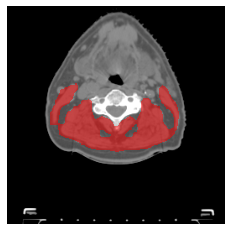

In [ ]:
#test_output[test_output == 0] = np.nan
sigmoid = 1/(1 + np.exp(-test_output))
segment_pred = (sigmoid > 0.5).float()
#sigmoid[sigmoid == 0] = np.nan
segment_pred = (np.asarray(segment_pred)).astype(float)
print(segment_pred.shape)
segment_pred[6][segment_pred[6]==0] = np.nan
plt.imshow(test_em[6][0], cmap="gray")
plt.imshow(segment_pred[6][0], cmap = plt.cm.autumn , alpha = 0.5)
plt.axis('off')
#plt.colorbar()
print(segment_pred[6])

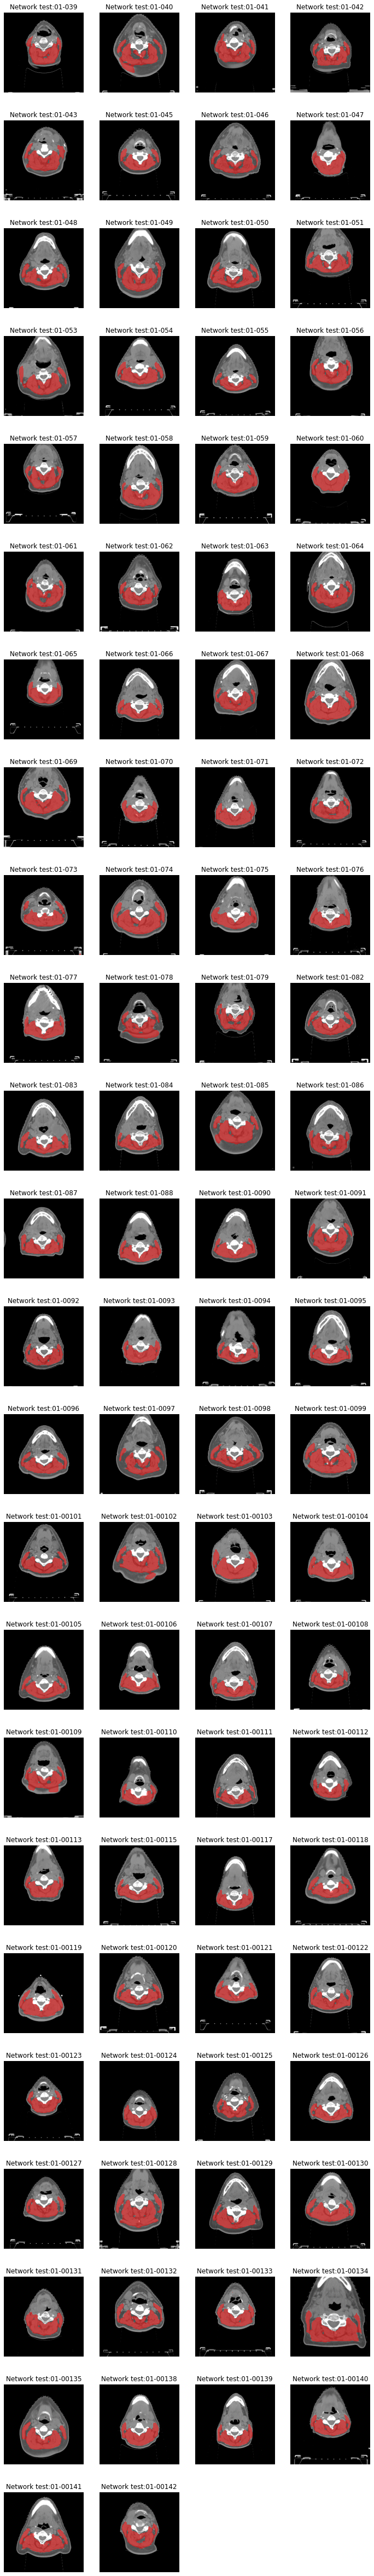

In [ ]:
sigmoid = 1/(1 + np.exp(-test_output))
segment_pred = (sigmoid > 0.5).float()
segment_pred[segment_pred==0] == np.nan
#plt.imshow(slice_test[0], cmap="Greys")
#plt.imshow(segment_pred[0][0], alpha = 0.5)
fig=plt.figure(figsize=(12, 90))
ax = []
rows = 25
columns = 4
#figure with 5 columns
for i in range(0, len(test_em)):
  ax.append(fig.add_subplot(rows, columns, i+1))
  #just cause they look cool 
  segment_pred[i][segment_pred[i]==0] = np.nan
  plt.imshow(test_em[i,0,...], cmap="gray")
  plt.imshow(segment_pred[i,0,...], cmap = plt.cm.autumn, alpha = 0.5)
  plt.axis('off')
  ax[-1].set_title("Network test:"+str(ids[i]))
plt.show()

Outputting all the test images.Just cause they're pretty.

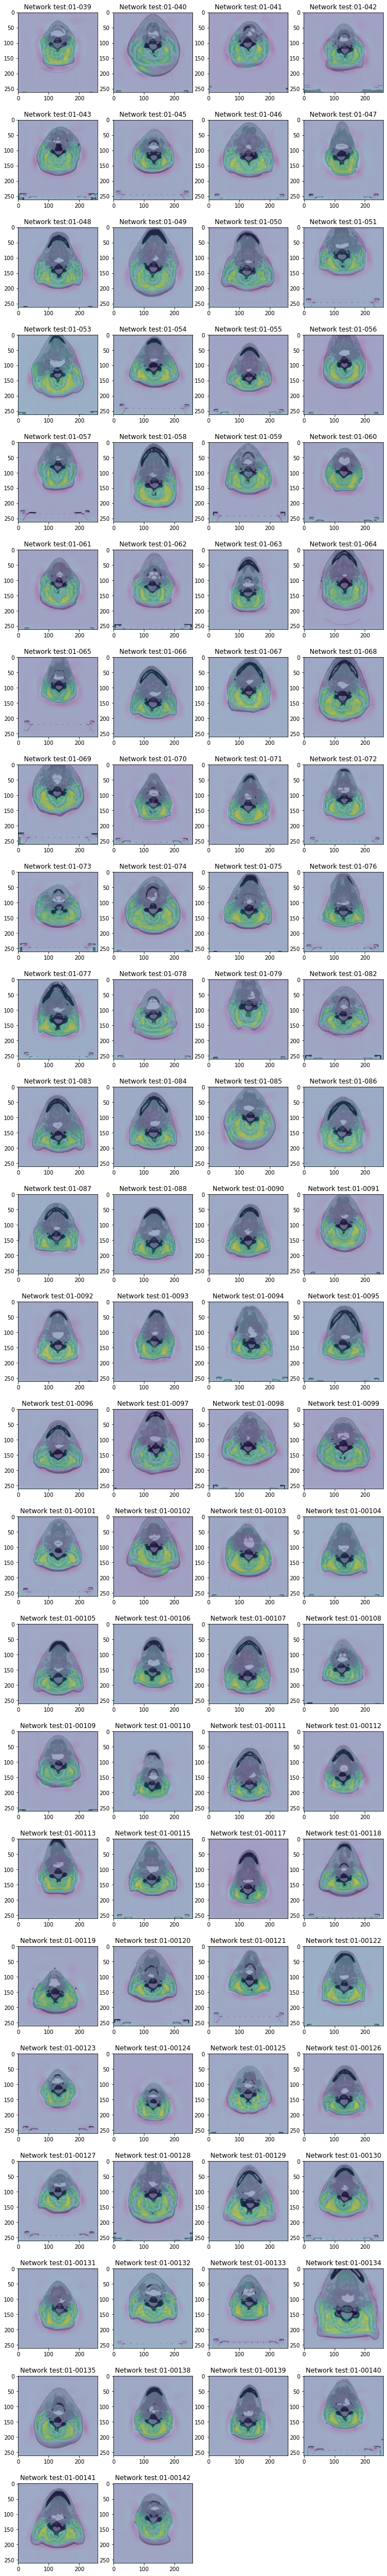

In [ ]:
fig=plt.figure(figsize=(12,90))
ax = []
#figure with 5 columns
for i in range(0, len(test_em)):
  ax.append(fig.add_subplot(rows, columns, i+1))
  #just cause they look cool 
  plt.imshow(test_em[i,0,...], cmap="Greys")
  plt.imshow(test_output[i,0,...], alpha = 0.5)
  plt.axis('off')
  #plt.colorbar()
  ax[-1].set_title("Network test:"+str(ids[i]))
plt.show()

Displaying the predictions that hae also been thresholded to take out values of bone and fat. (-30,130)

Save the masks to be compared with livs

In [ ]:
c3_segs = np.savez("/content/c3_segs", slices = slices, masks = segment_pred, ids=ids, pixel_areas = pixel_areas)

In [ ]:
c3_data = np.load("/content/c3_segs.npz", allow_pickle=True)

#Compare my Network's output with Livs
Do Dice between the networks sigmoided output and livs.


In [ ]:
#livs_segs = torch.from_numpy(masks_l_test.astype(np.int16))
#thresholded = torch.from_numpy(thresholded_seg)
mask_H = torch.from_numpy(masks_processed)

dice_net_v_pred = diceCoeff(mask_t, mask_t , smooth=1, activation=None)


print("dice_net_v_pred", dice_net_v_pred)
#print("dice_thres_v_net", dice_thres_net)
#print("dice_thres_v_pred", dice_thres_liv)
mean = np.mean(dice_net_v_pred.item())
#mean_thres_net = np.mean(dice_thres_net)
#mean_thres_liv = np.mean(dice_thres_liv)
print(mean)

#Area and Density of the Predictions

Calculate the area of the segment and get the muscel density in this area. make sure to use the unnormalised ct scans.

In [ ]:
ct_scans = slices

pixel area for each of my data bits. need to make sure they match up maybe add to array with identities.

In [ ]:
#pix_area = [0.87890625, 0.95367431640625, 0.95367431640625, 0.87890625, 0.9536694269690003, 0.9536694269690003, 0.87890625, 0.9536733850839028, 0.87890625, 0.9536694269690003, 0.9536694269690003, 0.9536694269690003, 0.9536694269690003, 0.95367431640625, 0.9536694269690003, 0.9536694269690003, 0.87890625, 0.9536694269690003, 0.95367431640625, 0.95367431640625, 0.95367431640625, 0.95367431640625, 0.9536733850839028, 0.87890625, 0.87890625, 0.87890625, 0.95367431640625, 0.95367431640625, 0.87890625, 0.87890625, 0.87890625, 0.87890625, 0.95367431640625, 0.46730049652979133, 0.95367431640625]
#mm^2
pixel_area_cm = np.array(pixel_areas)*(0.1*0.1) #cm^2
print(pixel_area_cm)

[0.00878906 0.00878906 0.00878906 0.00878906 0.00953674 0.00878906
 0.00953674 0.00953674 0.00953674 0.00953674 0.00878906 0.00878906
 0.00878906 0.00953674 0.00953674 0.00953674 0.00953674 0.00878906
 0.00878906 0.00953674 0.00953674 0.00878906 0.00878906 0.00878906
 0.00953674 0.00878906 0.00953674 0.00878906 0.00878906 0.00878906
 0.00878906 0.00953674 0.00953674 0.00878906 0.00953674 0.00878906
 0.00953674 0.00949863 0.00878906 0.00878906 0.00953674 0.00878906
 0.00953674 0.00878906 0.00953673 0.00953674 0.00953674 0.00953674
 0.00953669 0.00953674 0.00953674 0.00953674 0.00953674 0.00953674
 0.00878906 0.00878906 0.00953669 0.00953674 0.00878906 0.00953674
 0.00953674 0.00953674 0.00878906 0.00878906 0.00953674 0.00953674
 0.00878906 0.00953674 0.00953674 0.00878906 0.00878906 0.00953669
 0.00953674 0.00878906 0.00953674 0.00878906 0.00953674 0.01153946
 0.00878906 0.00953674 0.00953674 0.00878906 0.00878906 0.00878906
 0.00953674 0.00953673 0.00953674 0.00467295 0.00953674 0.0087

In [ ]:
def getDensity(image, mask, area, label=1):#pixel density
  if image.shape != (len(image),1,...):
    mask = np.squeeze(mask)
  # remove image.data since passing array
  return float(np.mean(image[np.where(mask == 1)]))#-1024

In [ ]:
def getArea(image, mask, area, label=1, thresholds = None):
  sMasks = (mask == label)
  threshold = np.logical_and(image > (thresholds[0]), image <  (thresholds[1]))
  tmask = np.logical_and(sMasks, threshold)
  #np.count_nonzero(tmask)
  return np.count_nonzero(tmask) * area

In [ ]:
getArea(ct_scans[16], segment_pred[16], pixel_area_cm[16], thresholds=(-326,-324))


41.33224487304688

In [ ]:
## Note that the areas have some thresholds applied that are from the literature
extractionDict = {"sma" : partial(getArea, thresholds=(-30, +130)), 
				  "smd" : partial(getDensity)
				 }
feat_list = ["sma","smd"]

# Extract features from slices_processed
feature_list = []
for i in range(0,len(ct_scans)):
	feature_list.append([extractionDict[a](ct_scans[i], segment_pred[i], pixel_area_cm[i]) for a in feat_list])

In [ ]:
print("Area, Density", feature_list)

Area, Density [[40.10449218750001, 14.14955499046408], [52.60253906250001, 7.21394426955812], [41.00976562500001, 0.25308731657707395], [33.58300781250001, 4.515539947322212], [52.96707153320313, 8.60971937029432], [35.03320312500001, 32.54843780703478], [45.20416259765626, -4.478185993111366], [43.88809204101563, 48.70019120458891], [47.063827514648445, 11.354253634662443], [54.74090576171876, 6.019892405855123], [45.17578125000001, 10.159328004335455], [43.61132812500001, 19.829968454258676], [51.18750000000001, 17.289254008215185], [52.33764648437501, 28.721938775510203], [28.55300903320313, 12.3915331260464], [47.750473022460945, 15.357772957339117], [40.67420959472657, 10.762731481481481], [49.56152343750001, 22.732061385317294], [54.588867187500014, 20.082536487166582], [52.26135253906251, 44.21800708143652], [49.009323120117195, 9.96131036430387], [33.34570312500001, 7.366781380184749], [34.00488281250001, 27.544516390125455], [48.14648437500001, 13.651743318409984], [37.3077392

#Sarcopenia Value

Looking at the skeletal muscle area. SMI.

In [ ]:
#smas = [f[0] for f in feature_list] #list way of doing it
sma = np.array(feature_list)[:,0]
mean_area = np.mean(sma)
area_sd = ndimage.standard_deviation(sma)
print(mean_area, "cm^2 ", "sd: ", area_sd)

44.9886565262757 cm^2  sd:  9.835878199285649


In [ ]:
smd = np.array(feature_list)[:,1]#sm attenuation
mean_density = np.mean(smd)
den_sd = ndimage.standard_deviation(smd)
print(mean_density, "HU" ,"sd", den_sd)

22.140984559191004 HU sd 13.575107374176907


In [ ]:
import pandas as pd

array = np.transpose(np.array(feature_list))
print(array)
df = pd.DataFrame(array, index= feat_list, columns=ids).T
df.to_excel(excel_writer = "/content/muscle_area_and_density_all_right_order_FINAL.xlsx")

[[40.10449219 52.60253906 41.00976563 33.58300781 52.96707153 35.03320313
  45.2041626  43.88809204 47.06382751 54.74090576 45.17578125 43.61132813
  51.1875     52.33764648 28.55300903 47.75047302 40.67420959 49.56152344
  54.58886719 52.26135254 49.00932312 33.34570313 34.00488281 48.14648438
  37.30773926 40.77246094 43.67828369 71.53417969 55.52929688 37.76660156
  46.74902344 43.33496094 51.67007446 77.12402344 50.81176758 40.53515625
  47.89352417 39.9987492  33.34570313 41.5546875  47.40715027 35.25292969
  64.83078003 40.1484375  44.05017366 44.87037659 44.11697388 57.78312683
  40.18762965 45.86219788 34.82818604 36.00120544 46.61560059 47.25456238
  40.078125   68.60742188 44.45053199 66.11824036 65.30273438 51.8989563
  44.88945007 38.48075867 41.07128906 29.07421875 48.53248596 31.16607666
  27.72070313 30.27915955 41.10336304 39.9375     33.1171875  41.48462007
  63.06648254 36.02636719 41.72325134 42.79394531 32.95898438 43.20375453
  26.60449219 38.2900238  38.06114197 6

In [ ]:
import pandas as pd
import numpy as np

train_loss = np.array([0.19041892766952515, 0.1417163848876953, 0.09265665292739868, 0.0728988254070282, 0.05940948486328125, 0.05622316122055054, 0.04960593104362488, 0.04688639640808105, 0.04298489451408386, 0.042703548669815065, 0.03967656135559082, 0.09777143955230713, 0.09256405115127564, 0.06443732500076294, 0.060311598777770994, 0.05289663195610046, 0.07707771301269531, 0.05633354067802429, 0.04964068651199341, 0.05739866375923157, 0.047312912940979, 0.0462168550491333, 0.042092142701148985, 0.047626767754554745, 0.03981478750705719, 0.03937737464904785, 0.04760479986667633, 0.03583461165428162, 0.03939599394798279, 0.03457685351371765, 0.03561633825302124, 0.061173802614212035, 0.050319255590438844, 0.041841131448745725, 0.044472959637641904, 0.04186204195022583, 0.04036375403404236, 0.038230645656585696, 0.03395204961299896, 0.038461651802062985, 0.03270158588886261, 0.03531438529491424, 0.03474985599517822, 0.03286379992961883, 0.031062504053115846, 0.031101420521736145, 0.03062666714191437, 0.03269613564014435, 0.030746842622756957, 0.0302423095703125, 0.029792304039001464, 0.028385266661643982, 0.027732686996459963, 0.03078183650970459, 0.030233221650123595, 0.03286764681339264, 0.028602383732795715, 0.028447113633155822, 0.028768059015274048, 0.028592174649238588, 0.029954161643981934, 0.02734544634819031, 0.02809032440185547, 0.027816044092178346, 0.02571342408657074, 0.026610957980155944, 0.032214871644973754, 0.031069273948669433, 0.028109681606292725, 0.028122268319129944, 0.026874667406082152, 0.027161089181900026, 0.025723463296890257, 0.02742850661277771, 0.02534696161746979, 0.02472287654876709, 0.024636636972427368, 0.02530574470758438, 0.02568528652191162, 0.028432589769363404, 0.025477765202522276, 0.024975568056106567, 0.030691000819206237, 0.025739719271659852, 0.024991640448570253, 0.02753529965877533, 0.025851642191410066, 0.030947336554527284, 0.026716020107269287, 0.024411031603813173, 0.03895457684993744, 0.02489603102207184, 0.027806180715560912, 0.025824888944625854, 0.027942193150520326, 0.028026903867721557, 0.028259338140487672, 0.027622456550598144, 0.026524484157562256, 0.026848905682563783, 0.024883779287338256, 0.025925969481468202, 0.02603893518447876, 0.025823326706886293, 0.02389694333076477, 0.02489308476448059, 0.027054165601730348, 0.023527165651321413, 0.026115389466285707, 0.02413721203804016, 0.025885396599769593, 0.023281028270721437, 0.024119478464126588, 0.024679229855537416, 0.02408091366291046, 0.022706642746925354, 0.022599514722824097, 0.022783066034317016, 0.022551727294921876, 0.023565533757209777, 0.0241068696975708, 0.02702372908592224, 0.024795972108840943, 0.03605425953865051, 0.024436095356941225, 0.028109565377235413, 0.02766811490058899, 0.022878409624099733, 0.021932911276817322, 0.02158194988965988, 0.02153675466775894, 0.02372533142566681, 0.022599360346794127, 0.022943207621574403, 0.023337966799736022, 0.021339486837387085, 0.027399685382843018, 0.023899710178375243, 0.02247693121433258, 0.022831913232803345, 0.024455332159996034, 0.022402988076210023, 0.022825695872306824, 0.025463799834251403, 0.02507485032081604, 0.024228346943855287, 0.02443136751651764, 0.02195951133966446, 0.02466457962989807, 0.022136777639389038, 0.022081370949745178, 0.021447877287864684, 0.02135720431804657, 0.021136867702007293, 0.022469014525413514, 0.021918563246726988, 0.022006059288978575, 0.024239615797996522, 0.023363158106803894, 0.022038863301277162, 0.023374541401863097, 0.021797537803649902, 0.02355488121509552, 0.023838485479354857, 0.021121882796287537, 0.02254022717475891, 0.020764490067958833, 0.02108344554901123, 0.02146055579185486, 0.023791134655475617, 0.02403497666120529, 0.022847926914691924, 0.020817308723926543, 0.024566851258277893, 0.021467710733413695, 0.021113928854465485, 0.02175378829240799, 0.02138403296470642, 0.02079467475414276, 0.021360259354114532, 0.021586592495441436, 0.023391698598861695, 0.022627995610237123, 0.0220535546541214, 0.02158697009086609, 0.020837196111679078, 0.022925858795642854, 0.024041187763214112, 0.024670363068580628, 0.021442546248435973, 0.02186612129211426, 0.02339958518743515, 0.02056789070367813, 0.021343204379081725, 0.023844441771507262, 0.02182230681180954, 0.020606201589107514, 0.020180681049823762, 0.02180413782596588, 0.019583544731140136, 0.0211384716629982, 0.044081605076789855, 0.023111205101013183, 0.02040984243154526, 0.020728800892829895, 0.020180501341819763, 0.023063775300979614, 0.021716637015342714, 0.02018605709075928, 0.021423681080341338, 0.02246823489665985, 0.020706309676170348, 0.020986645519733428, 0.02331521451473236, 0.021790941059589387, 0.020534895956516266, 0.020522502660751344, 0.021757962703704833, 0.020579808056354523, 0.022094849348068237, 0.023163381218910217, 0.02069901078939438, 0.021674899756908415, 0.01960202872753143, 0.021015645861625673, 0.02681864082813263, 0.021383988559246062, 0.022982053756713867, 0.021155485510826112, 0.01934513181447983, 0.024428619742393493, 0.02458299547433853, 0.022608869075775147, 0.021512900590896607, 0.022488253712654113, 0.021762677133083344, 0.022015790939331054, 0.021178467869758605, 0.022437973022460936, 0.02104283928871155, 0.02945249617099762, 0.022150018811225893, 0.051990479826927186, 0.023109804093837737, 0.021649990677833558, 0.020790335536003113, 0.0203947651386261, 0.018959065973758696, 0.021463616788387298, 0.019302180409431456, 0.02150465428829193, 0.021245321929454802, 0.023198979794979094, 0.01953675627708435, 0.020646301805973055, 0.02198491185903549, 0.02154893785715103, 0.02030141234397888, 0.02003872811794281, 0.023411523699760437, 0.020567738115787507, 0.02184541553258896, 0.02199299931526184, 0.02044388473033905, 0.02161977231502533, 0.02111401617527008, 0.020690959095954895, 0.020103899240493776, 0.025236102938652038, 0.022550085186958314, 0.020003750324249267, 0.021375952064991, 0.020712559521198274, 0.022173896729946137, 0.02483960658311844, 0.021677807569503785, 0.02178871214389801, 0.020470224022865295, 0.024683534801006317, 0.024344708621501922, 0.020289394557476043, 0.021509450674057008, 0.02215238839387894, 0.020841636657714845, 0.020671851336956024, 0.02120897740125656, 0.021595251560211182, 0.022114633619785308, 0.019581414461135864, 0.030262144804000853, 0.023184747099876404, 0.02626906633377075, 0.021659729182720185, 0.02147668123245239, 0.022499635815620422, 0.019762206971645355, 0.02192955493927002, 0.01950593203306198, 0.02145131677389145, 0.020481606721878053])
val_loss =  np.array([3.6612308502197264, 0.3812385082244873, 0.48743548393249514, 0.5299258708953858, 0.4992224216461182, 0.4929614543914795, 0.5023656845092773, 0.5229888916015625, 0.5474568843841553, 0.5708550930023193, 0.5977982997894287, 0.5994325637817383, 0.7449556350708008, 0.7049273014068603, 0.6090092182159423, 0.5366583824157715, 0.503687047958374, 0.7062724113464356, 0.7252144813537598, 0.6581811428070068, 0.6254674434661865, 0.6294657707214355, 0.6370576381683349, 0.6331723213195801, 0.6175317287445068, 0.5222886085510254, 0.5174428939819335, 0.569409704208374, 0.5465474128723145, 0.5195575714111328, 0.4977846622467041, 0.6526554584503174, 0.10920079946517944, 0.5768791675567627, 0.4578702926635742, 0.2981573104858398, 0.3019448518753052, 0.21608901023864746, 0.03931308686733246, 0.03796949088573456, 0.04388684034347534, 0.03889797627925873, 0.05244410037994385, 0.25871074199676514, 0.20581583976745604, 0.040845608711242674, 0.08590586185455322, 0.07995518445968627, 0.0342018723487854, 0.06004612445831299, 0.035716238617897036, 0.03297376930713654, 0.0325121134519577, 0.03366252183914185, 0.046549233794212344, 0.047639912366867064, 0.03325561583042145, 0.033804744482040405, 0.043113553524017335, 0.03272980153560638, 0.031367987394332886, 0.031646573543548585, 0.041920581459999086, 0.03966472446918488, 0.04171047210693359, 0.03713135719299317, 0.031209063529968262, 0.4814143657684326, 0.5254428863525391, 0.1768495559692383, 0.0543592631816864, 0.13442322015762329, 0.07965574860572815, 0.03195305466651917, 0.030573064088821413, 0.03412691056728363, 0.048476231098175046, 0.10622308254241944, 0.14501286745071412, 0.04331612884998322, 0.032042321562767026, 0.031067445874214172, 0.029821375012397768, 0.03139980137348175, 0.03165190815925598, 0.03431009948253631, 0.03372637629508972, 0.029118716716766357, 0.03367040455341339, 0.04534143805503845, 0.07176334857940674, 0.08302093148231507, 0.044802770018577576, 0.05554550886154175, 0.19607499837875367, 0.21848623752593993, 0.1766922116279602, 0.14860591888427735, 0.14216814041137696, 0.13662151098251343, 0.13479366302490234, 0.15179598331451416, 0.1454243540763855, 0.1229852557182312, 0.0873828411102295, 0.06176272630691528, 0.05978211760520935, 0.04365006983280182, 0.03333980143070221, 0.031822812557220456, 0.029243674874305726, 0.027280727028846742, 0.02723696529865265, 0.027524322271347046, 0.028064897656440733, 0.027895110845565795, 0.02746434509754181, 0.026831790804862976, 0.026799696683883666, 0.027568292617797852, 0.030074569582939147, 0.02931635081768036, 0.027384164929389953, 0.03407014012336731, 0.027424541115760804, 0.02731076180934906, 0.026822638511657716, 0.02658320963382721, 0.026400798559188844, 0.026767322421073915, 0.027076885104179382, 0.02652323842048645, 0.026499783992767333, 0.026051232218742372, 0.025914233922958375, 0.025872957706451417, 0.026037994027137756, 0.02651086151599884, 0.02787923812866211, 0.02893153131008148, 0.02850211560726166, 0.029307961463928223, 0.029443860054016113, 0.029100143909454347, 0.027253565192222596, 0.026146981120109557, 0.025932344794273376, 0.0258466899394989, 0.025778523087501524, 0.027163967490196228, 0.02708272635936737, 0.026179677248001097, 0.025714701414108275, 0.02543107271194458, 0.02542964518070221, 0.025459980964660643, 0.025505468249320984, 0.02572915256023407, 0.025874307751655577, 0.025707805156707765, 0.02542944848537445, 0.025365087389945983, 0.025343382358551027, 0.025419336557388306, 0.025445368885993958, 0.025541308522224426, 0.025503337383270264, 0.025460243225097656, 0.02550985515117645, 0.025630894303321838, 0.025510191917419434, 0.025772258639335632, 0.02625577449798584, 0.025891810655593872, 0.025233757495880128, 0.02517299950122833, 0.025098970532417296, 0.025071486830711365, 0.025052151083946227, 0.025005143880844117, 0.02499803751707077, 0.025073066353797913, 0.02510995864868164, 0.02512691020965576, 0.02514229714870453, 0.025153729319572448, 0.02525510489940643, 0.02525967061519623, 0.02506747543811798, 0.025038206577301027, 0.025121793150901794, 0.025077801942825318, 0.024980151653289796, 0.025005257129669188, 0.02514600455760956, 0.025253427028656007, 0.025279322266578676, 0.025134387612342834, 0.025007182359695436, 0.024971361458301543, 0.024983081221580505, 0.024839307367801666, 0.025132882595062255, 0.025183907151222228, 0.02523115575313568, 0.025219747424125673, 0.025021463632583618, 0.02501339018344879, 0.02491893470287323, 0.024910517036914825, 0.024864797294139863, 0.024833594262599946, 0.02489175945520401, 0.024897000193595885, 0.024927376210689543, 0.024906286597251893, 0.024910952150821685, 0.02495657652616501, 0.0249170258641243, 0.02485969811677933, 0.024803772568702698, 0.02478947639465332, 0.024831731617450715, 0.024867695569992066, 0.024895307421684266, 0.02490509897470474, 0.02487112581729889, 0.024830995500087737, 0.024863983690738677, 0.024861155450344084, 0.024885955452919006, 0.02484051138162613, 0.024825514853000642, 0.02476002722978592, 0.024775606393814088, 0.02474646419286728, 0.024721957743167877, 0.02476915717124939, 0.024802251160144805, 0.024844656884670257, 0.024819475412368775, 0.024781662225723266, 0.025426965951919556, 0.02627291977405548, 0.02609429955482483, 0.025836998224258424, 0.025444886088371275, 0.024919886887073518, 0.024852932989597322, 0.024821726977825163, 0.02475379705429077, 0.0247132807970047, 0.02470870465040207, 0.024727287888526916, 0.024703273177146913, 0.02470463216304779, 0.024717062711715698, 0.02480613887310028, 0.02487151026725769, 0.02475937008857727, 0.02480529546737671, 0.024787208437919615, 0.02476290762424469, 0.024734969437122344, 0.02477251589298248, 0.02477971464395523, 0.024767978489398955, 0.024800056219100954, 0.024619124829769135, 0.024661219120025633, 0.024612380564212798, 0.02457573115825653, 0.024551975727081298, 0.024673476815223694, 0.024694432318210603, 0.024654687941074373, 0.02463437020778656, 0.024675476551055908, 0.024744808673858643, 0.024795179069042207, 0.02475391626358032, 0.024738861620426177, 0.024715107679367066, 0.024729420244693757, 0.02468082457780838, 0.024703559279441834, 0.024708357453346253, 0.02467302232980728, 0.024673111736774445, 0.024620118737220763, 0.02456851452589035, 0.024644020199775695, 0.02465495318174362, 0.024688956141471863, 0.024721108376979828, 0.02479093670845032, 0.02468836009502411, 0.02477148622274399, 0.02471645325422287, 0.024623918533325195])


array = np.transpose(np.concatenate((train_loss, val_loss)))
print(array)
loss = np.savetxt("/content/loss.csv", array, delimiter=',')

[0.19041893 0.14171638 0.09265665 0.07289883 0.05940948 0.05622316
 0.04960593 0.0468864  0.04298489 0.04270355 0.03967656 0.09777144
 0.09256405 0.06443733 0.0603116  0.05289663 0.07707771 0.05633354
 0.04964069 0.05739866 0.04731291 0.04621686 0.04209214 0.04762677
 0.03981479 0.03937737 0.0476048  0.03583461 0.03939599 0.03457685
 0.03561634 0.0611738  0.05031926 0.04184113 0.04447296 0.04186204
 0.04036375 0.03823065 0.03395205 0.03846165 0.03270159 0.03531439
 0.03474986 0.0328638  0.0310625  0.03110142 0.03062667 0.03269614
 0.03074684 0.03024231 0.0297923  0.02838527 0.02773269 0.03078184
 0.03023322 0.03286765 0.02860238 0.02844711 0.02876806 0.02859217
 0.02995416 0.02734545 0.02809032 0.02781604 0.02571342 0.02661096
 0.03221487 0.03106927 0.02810968 0.02812227 0.02687467 0.02716109
 0.02572346 0.02742851 0.02534696 0.02472288 0.02463664 0.02530574
 0.02568529 0.02843259 0.02547777 0.02497557 0.030691   0.02573972
 0.02499164 0.0275353  0.02585164 0.03094734 0.02671602 0.0244